In [2]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud

Step 1: Load Data

In [3]:
df = pd.read_excel("Copy of Arabic_offensive_comment_detection(1).xlsx")
print("Initial Dataset:")
df.head()

Initial Dataset:


,Id,Platform,Comment,Majority_Label,Agreement,NumOfJudgementUsed,Total_Judgement,Vulgar:V/HateSpeech:HS/None:-
0,1,Twitter,@User.IDX في فترة الصغر والمراهقة يكون من الصع...,Non-Offensive,100.0,3,3,-
1,2,Facebook,"""ردا على معظم الردود .. أحب اوضحلكم ان عمليات ...",Non-Offensive,100.0,3,4,-
2,3,Twitter,@User.IDX يجب ان تذكروا ان لكل سنة ثيم للحفل و...,Non-Offensive,100.0,3,5,-
3,4,YouTube,بتعمل حلقة صغيرة عشان عندي امتحان بكرة ومتضيعل...,Non-Offensive,100.0,3,3,-
4,5,YouTube,على طاري السطحيه مدري ليه تذكرت فيحان,Non-Offensive,100.0,3,3,-


In [4]:
# Display initial dataset
print("\nDataset Columns:")
print(df.columns)


Dataset Columns:
Index(['Id', 'Platform', 'Comment', 'Majority_Label', 'Agreement',
       'NumOfJudgementUsed', 'Total_Judgement',
       'Vulgar:V/HateSpeech:HS/None:-'],
      dtype='object')


Step 2: Load Arabic Stopwords

In [5]:
# Download stopwords
nltk.download('stopwords')

# Load Arabic stopwords
stop_word_arabic = set(stopwords.words("arabic"))
print(len(stop_word_arabic))



701


[nltk_data] Downloading package stopwords to C:\Users\ahmed
[nltk_data]     yasser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
' - '.join(stop_word_arabic)

'أمّا - نا - عاشر - نَخْ - إليكم - حاء - لهما - هَذانِ - ؤ - زعم - فإذا - فيما - ليسا - ذِه - متى - ستة - مكانكم - تعلَّم - صبرا - تحوّل - وما - يورو - منه - لكيلا - أيلول - زود - فيها - أهلا - حبذا - نوفمبر - خلا - إياه - بخ - تعسا - سادس - تشرين - أينما - ض - لكنما - أرى - على - هنالك - إياك - أبٌ - بكن - ذلكن - بهما - واحد - ف - خاصة - والذي - جنيه - ذيت - اللذين - بمن - أطعم - خبَّر - تي - منها - أم - ثمانون - ياء - ظاء - وراءَك - اللتيا - ممن - كلاهما - أنًّ - رجع - صبر - فوق - اخلولق - سبعين - إذ - أربعاء - غير - إليكنّ - تاسع - بس - ثم - ثاء - آنفا - تلقاء - معاذ - حدَث - إذما - كأنّ - عليه - آناء - ستمائة - إياكن - لا - أمام - كأين - إذن - غادر - اللائي - ولكن - ثلاثة - نفس - وا - كأنما - حقا - ثلاث - ضحوة - ست - وهو - تفعلان - أفعل به - همزة - قرش - خمسين - الألاء - ن - عوض - هذا - هذي - دون - أنتما - إيانا - ذَيْنِ - كليكما - ل - ثالث - حيَّ - يوان - سبعة - كِخ - لا سيما - ذا - غداة - عشر - أخو - كيت - هَاتانِ - ث - أل - تجاه - أيّان - ليسوا - ء - صهْ - لهم - سنتيم - أقل - هَ

Step 3: Initialize Stemmer

In [6]:
stemmer = ISRIStemmer()

def simple_tokenize(text):
    return text.split()

 Step 4: Text Preprocessing Function

In [7]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"@\w+", "", text)  # Remove mentions (@User.IDX)
    text = re.sub(r"[\\d,؛?؟!.,:(){}\[\]\-]", " ", text)  # Remove punctuation & special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    words = simple_tokenize(text)  # Tokenize text
    words = [word for word in words if word not in stop_word_arabic]  # Remove stopwords
    words = [stemmer.stem(word) for word in words]  # Apply stemming
    return " ".join(words)

Step 5: Apply Preprocessing

In [8]:
if "Comment" in df.columns:
    df["cleaned_text"] = df["Comment"].apply(preprocess_text)
else:
    print("Error: Column 'Comment' not found in dataset.")

Step 6: Define Regex Patterns

In [9]:
patterns = {
    "repeated_words": re.compile(r"\b(\w+)( \1)+\b"),  # Detect repeated words (e.g., "جدا جدا")
    "emojis": re.compile(r"[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]"),  # Detect emojis
    "common_suffixes": re.compile(r"\w+(\u064a\u0629|\u064a\u0627\u062a|\u064a\u0646|\u0648\u0646|\u0627\u0646|\u062a\u0645|\u062a\u0647|\u0647\u0627|\u0643\u0645|\u0647\u0645|\u0646\u0627)\b")  # Detect common Arabic suffixes
}

 Step 7: Extract Patterns

In [10]:
def extract_patterns(text, pattern):
    return pattern.findall(text) if isinstance(text, str) else []

if "cleaned_text" in df.columns:
    df["repeated_words"] = df["cleaned_text"].apply(lambda x: extract_patterns(x, patterns["repeated_words"]))
    df["emojis"] = df["Comment"].apply(lambda x: extract_patterns(x, patterns["emojis"]))
    df["suffixes"] = df["cleaned_text"].apply(lambda x: extract_patterns(x, patterns["common_suffixes"]))


Step 8: Display Basic Analysis

In [11]:
print("\nCleaned Dataset Sample:")
print(df.head())


Cleaned Dataset Sample:
   Id  Platform                                            Comment  \
0   1   Twitter  @User.IDX في فترة الصغر والمراهقة يكون من الصع...   
1   2  Facebook  "ردا على معظم الردود .. أحب اوضحلكم ان عمليات ...   
2   3   Twitter  @User.IDX يجب ان تذكروا ان لكل سنة ثيم للحفل و...   
3   4   YouTube  بتعمل حلقة صغيرة عشان عندي امتحان بكرة ومتضيعل...   
4   5   YouTube             على طاري السطحيه مدري ليه تذكرت فيحان    

  Majority_Label  Agreement  NumOfJudgementUsed  Total_Judgement  \
0  Non-Offensive      100.0                   3                3   
1  Non-Offensive      100.0                   3                4   
2  Non-Offensive      100.0                   3                5   
3  Non-Offensive      100.0                   3                3   
4  Non-Offensive      100.0                   3                3   

  Vulgar:V/HateSpeech:HS/None:-  \
0                             -   
1                             -   
2                             -   
3    

Step 9: Data Analysis & Visualization

In [12]:
if "Label" in df.columns:
    # 1. Sentiment Distribution
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x="Label", palette="viridis")
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()
else:
    print("Error: Column 'Label' not found in dataset.")


Error: Column 'Label' not found in dataset.


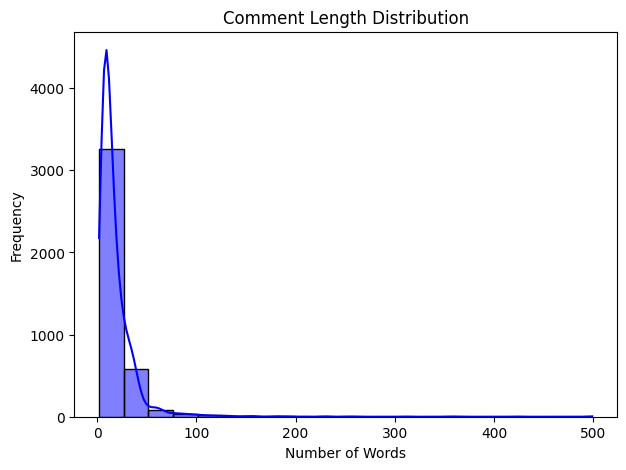

In [14]:
# 3. Comment Length Distribution
if "cleaned_text" in df.columns:
    comment_lengths = df["cleaned_text"].apply(lambda x: len(x.split()))
    plt.figure(figsize=(7,5))
    sns.histplot(comment_lengths, bins=20, kde=True, color="blue")
    plt.title("Comment Length Distribution")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.show()

Step 10: Save Processed Data

In [ ]:
processed_file_path = "processed_arabic_comments.xlsx"
df.to_excel(processed_file_path, index=False)


In [ ]:
print(" Data preprocessing completed successfully!")


 Data preprocessing completed successfully!
